# **Launch Sites Locations Analysis with Folium**

## **Objectives**
This lab contains the following tasks:

**TASK 1:** Mark all launch sites on a map

**TASK 2:** Mark the success/failed launches for each site on the map

**TASK 3:** Calculate the distances between a launch site to its proximities
After completed the above tasks, you should be able to find some geographical patterns about launch sites.

In [1]:
!pip3 install folium
!pip3 install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=342a949b931342dc2161f9c92819e437a4bf6a7f8e4d9c41da713196af793991
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [2]:
import folium
import wget
import pandas as pd

In [3]:
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

## **Task 1: Mark all launch sites on a map**

In [4]:
# Download and read the `spacex_launch_geo.csv`
spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
spacex_df=pd.read_csv(spacex_csv_file)

In [5]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


The given coordinates are not easy to understand as they are just numerical values. If someone is skilled in geography, they may be able to comprehend the locations represented by those numbers mentally. However, for those who are not proficient in geography, it can be challenging. To make it easier, we need to plot those coordinates on a map using a folium Map object. We will set the initial center of the map to NASA Johnson Space Center located in Houston, Texas.

In [6]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

In [7]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

In [8]:
# Initial the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for launch_site, site_lat, site_long in zip(launch_sites_df['Launch Site'], launch_sites_df['Lat'], launch_sites_df['Long']):
    site_coordinate = [site_lat, site_long]
    
    circle = folium.Circle(site_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup(launch_site))
    
    marker = folium.map.Marker(
        site_coordinate,
        # Create an icon as a text label
        icon=DivIcon(
            icon_size=(20, 20),
            icon_anchor=(0, 0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % launch_site,
            )
        )
    site_map.add_child(circle)
    site_map.add_child(marker)
site_map

You can now explore the map and zoom in or out on the marked areas to answer the following questions: Are all the launch sites located near the Equator? Are they all very close to the coast? Based on the findings, it can be explained that most of the launch sites in this project are near the Equator as launching from there allows the spacecraft to gain more speed due to the Earth's rotation. Launch sites are also located near the coast to minimize the risk of debris falling or exploding near populated areas.

## **Task 2: Mark the success/failed launches for each site on the map**

The next step is to improve the map by including information about the launch outcomes for each site. This will help identify the sites that have a high rate of successful launches. Remember that the launch data is stored in the data frame called "spacex_df", and the "class" column specifies whether the launch was successful or not.

In [9]:
spacex_df.tail(10)

,Launch Site,Lat,Long,class
46,KSC LC-39A,28.573255,-80.646895,1
47,KSC LC-39A,28.573255,-80.646895,1
48,KSC LC-39A,28.573255,-80.646895,1
49,CCAFS SLC-40,28.563197,-80.576820,1
50,CCAFS SLC-40,28.563197,-80.576820,1
51,CCAFS SLC-40,28.563197,-80.576820,0
52,CCAFS SLC-40,28.563197,-80.576820,0
53,CCAFS SLC-40,28.563197,-80.576820,0
54,CCAFS SLC-40,28.563197,-80.576820,1
55,CCAFS SLC-40,28.563197,-80.576820,0


The next step is to make markers for all the launch records on the map. Green markers will be used for successful launches (class=1), and red markers will be used for failed launches (class=0). Because launches only occur in one of the four launch sites, multiple launch records will have the same coordinates. To simplify the map and avoid overcrowding, we can use marker clusters to group markers with the same coordinates.

In [10]:
marker_cluster = MarkerCluster()

Create a new column in the dataframe named 'launch_sites', and label it as 'marker_color'. This column will contain the marker colors determined by the class value.

In [11]:
# Apply a function to check the value of `class` column
# If class=1, marker_color value will be green
# If class=0, marker_color value will be red
spacex_df['marker_color'] = list(map(lambda x: 'green' if x==1 else 'red', spacex_df['class']))
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


In [12]:
# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


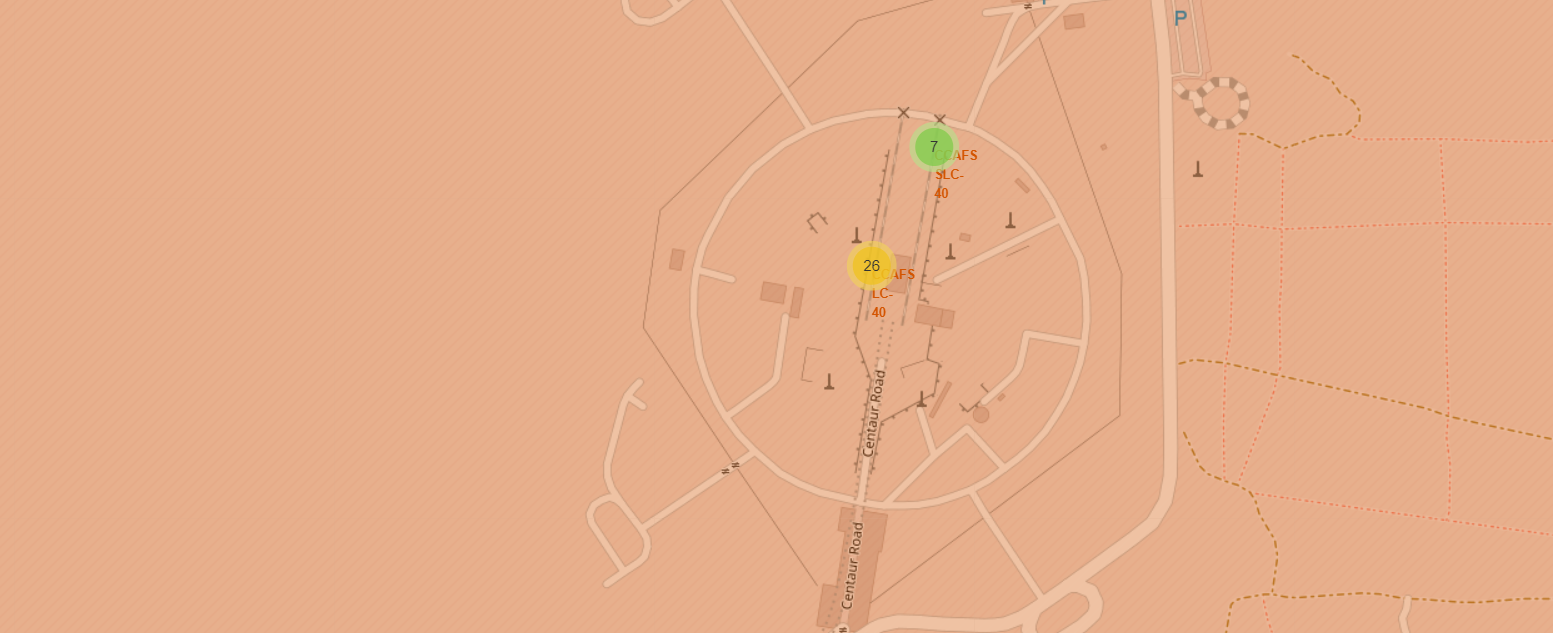

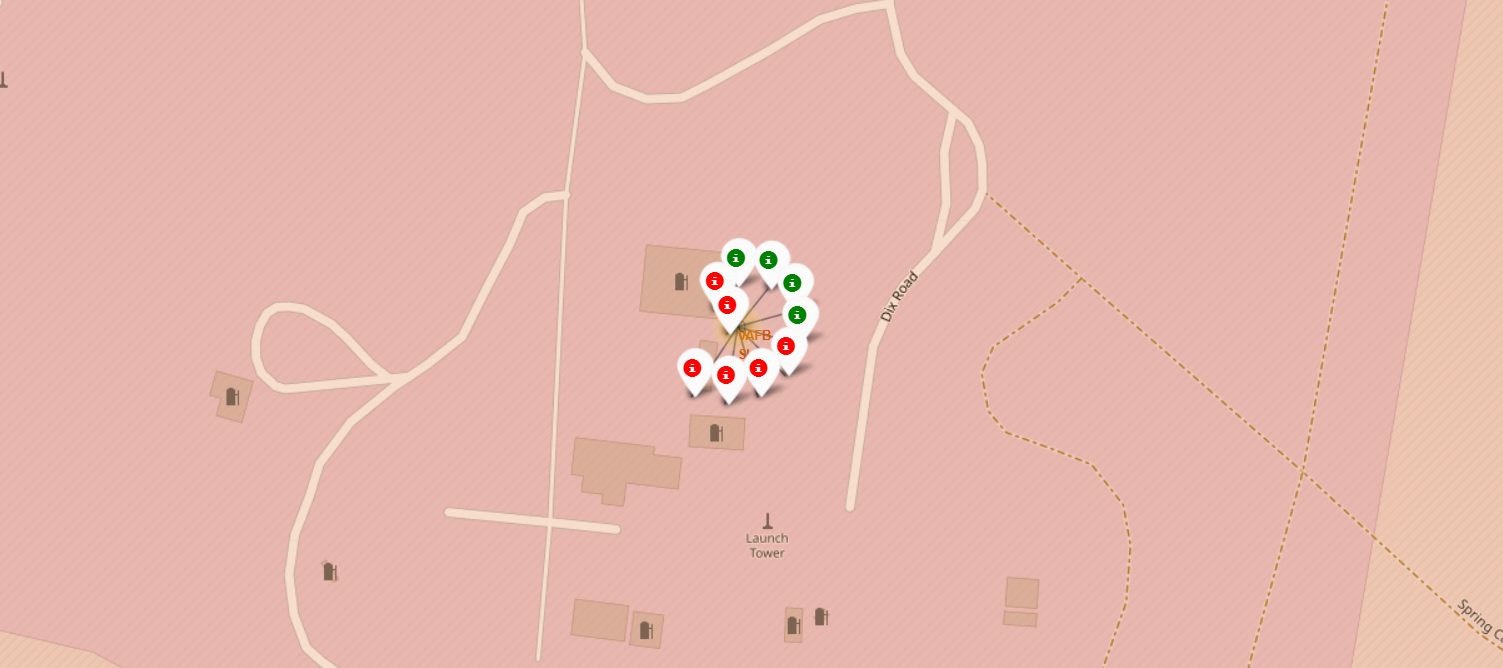

The instruction is to iterate through each launch result in the "spacex_df" data frame and create a folium.Marker for it. Additionally, each of these markers should be added to a "marker_cluster".

In [14]:
# Add the Marker cluster to the site map
site_map.add_child(marker_cluster)

# for each row in spacex_df data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for site_lat, site_long, marker_color in zip(spacex_df['Lat'], spacex_df['Long'], spacex_df['marker_color']):
    site_coordinate = [site_lat, site_long]
    marker = folium.map.Marker(
        site_coordinate,
        # Create an icon as a text label
        icon=folium.Icon(color='white', 
                         icon_color=marker_color)
    )
    marker.add_to(marker_cluster)

site_map

## **TASK 3: Calculate the distances between a launch site to its proximities**

In [15]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

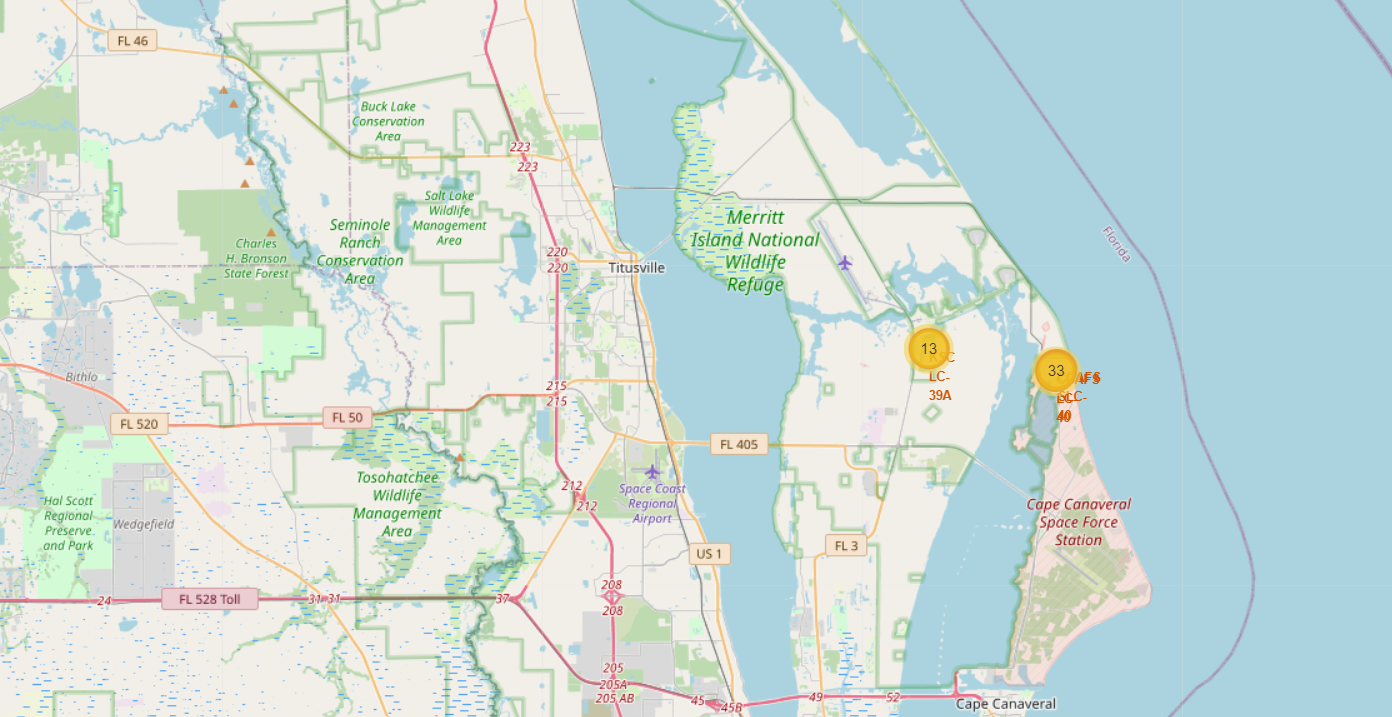

To find out if there are any nearby transportation routes or geographical features in the vicinity of a launch site, you should zoom in and explore the map. If you come across any significant locations such as railways, highways, or coastlines, take note of their coordinates, which are displayed on the top-left corner of the map. You can use these coordinates to calculate the distance between the location and the launch site by using the latitude and longitude values of each point.

In [16]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

First, using the MousePosition tool, identify and mark a point on the railway that is closest to the launch site. Then, calculate the distance between this marked railway point and the launch site.

In [17]:
# distance_railway = calculate_distance(lat1, lon1, lat2, lon2)
railway_marker = [28.55752, -80.80155]
launch_coordinate = [28.57337, -80.64669]
distance_railway = calculate_distance(railway_marker[0], railway_marker[1], launch_coordinate[0], launch_coordinate[1])
distance_railway  # distance in km

15.230651245141603

After acquiring the coordinate, generate a folium.Marker to indicate the distance.

In [18]:
# create and add a folium.Marker on your selected closest raiwaly point on the map
# show the distance to the launch site using the icon property 
marker = folium.map.Marker(
        railway_marker,
        # Create an icon as a text label
        icon=DivIcon(
            icon_size=(400, 400),
            icon_anchor=(0, 0),
            html='<div style="font-size:400; color:#0c10f2;"><b>%s</b></div>' % str(round(distance_railway, 2))+' km',
            )
    )
marker.add_to(site_map)

site_map

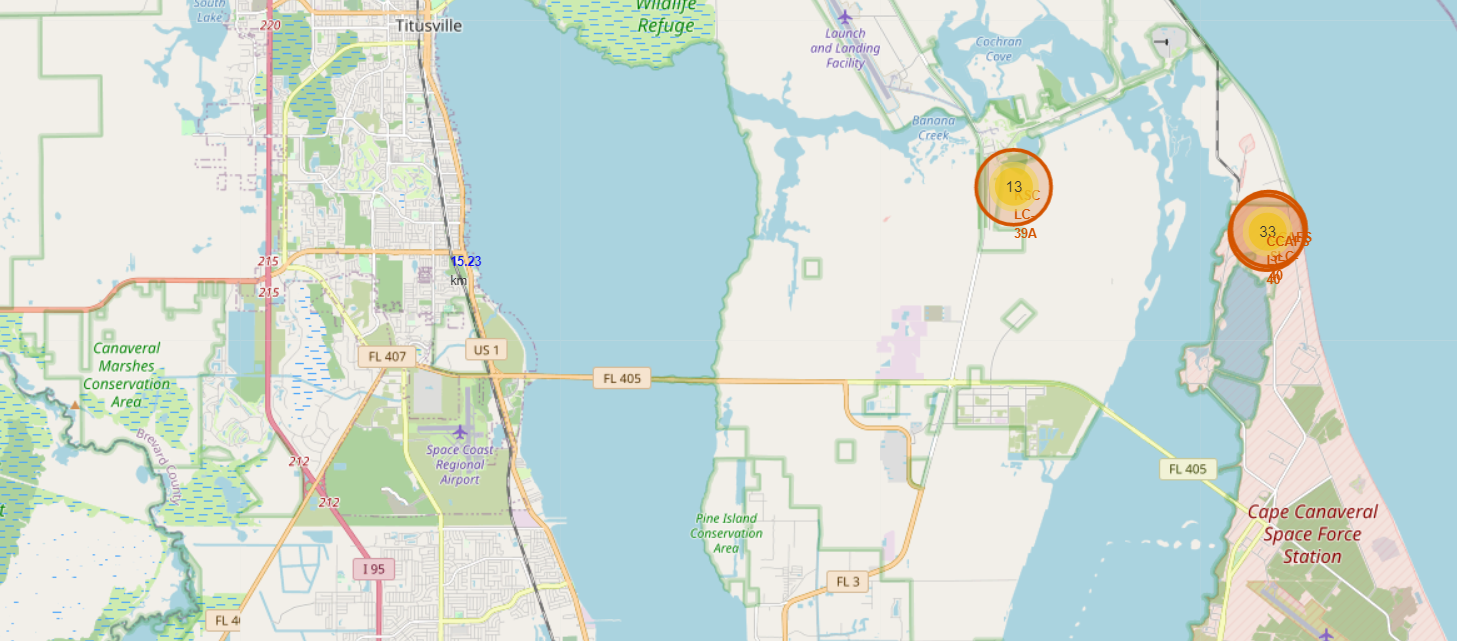

The task at hand is to create a PolyLine connecting a launch site with a chosen destination.

In [19]:
# Create a `folium.PolyLine` object using the railway point coordinate and launch site coordinate
folium.PolyLine([railway_marker, launch_coordinate], color='blue').add_to(site_map)
site_map

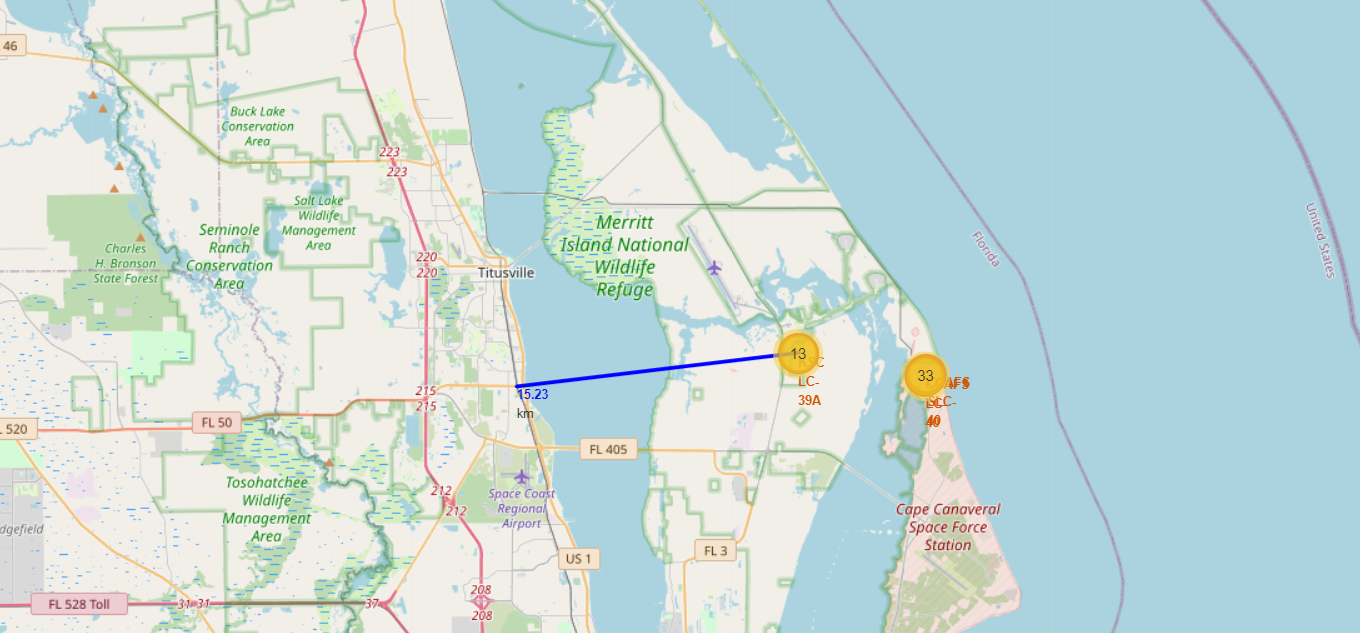

To clarify, you can create a connection between a launch location and its nearest urban area, coastline, major roadways, and other relevant features.

In [20]:
# Create a marker with distance to a closest city, coastline, highway, etc.
# Draw a line between the marker to the launch site
city   = [28.61200, -80.80788]
coastline = [28.5858, -80.79952]
highway   = [28.5402, -80.85079]

city_distance = calculate_distance(city[0], city[1], launch_coordinate[0], launch_coordinate[1])
coastline_distance = calculate_distance(coastline[0], coastline[1], launch_coordinate[0], launch_coordinate[1])
highway_distance = calculate_distance(highway[0], highway[1], launch_coordinate[0], launch_coordinate[1])

colors = ['red','orange','green']
html_colors = ['#dc3545','#fd7e14','#198754']

for coordinate ,distance, color, html_color in zip([city, coastline, highway], [city_distance, coastline_distance, highway_distance], colors, html_colors):
    marker = folium.map.Marker(
            coordinate,
            # Create an icon as a text label
            icon=DivIcon(
                icon_size=(20,20),
                icon_anchor=(0,0),
                html='<div style="font-size: 12; color:'+html_color+';"><b>%s</b></div>' % str(round(distance, 2)) + 'km',
                )
            )
    marker.add_to(site_map)
    folium.PolyLine([coordinate, launch_coordinate], color=color).add_to(site_map)
site_map

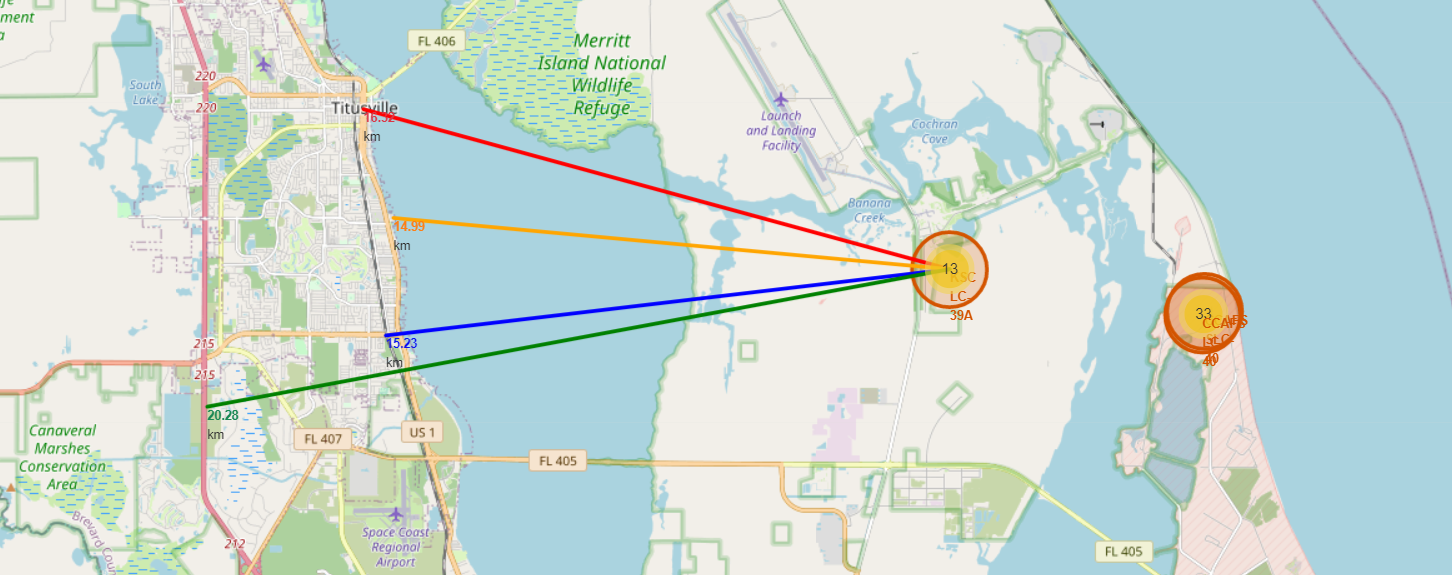